# EDA

## Подготовка среды выполнения и загрузка файла

In [1]:
!pip install pymystem3 python-rake wordcloud gensim pyLDAvis

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from yellowbrick.classifier import ClassificationReport
import pandas_profiling

import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import matplotlib.pyplot as plt


from nltk import tokenize
from pymystem3 import Mystem
from nltk import FreqDist

import warnings
warnings.filterwarnings('ignore')

/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/Users/yanasklyanchuk/opt/anaconda3/lib/python3.9/site-packages/visions/backends/shared/nan_handling.py:

In [3]:
RANDOM_STATE = 12345
targets = 'Категория'
text = ['Название']

In [4]:
df = pd.read_csv('table_for_category_classification.csv', sep=',', on_bad_lines='skip')


In [5]:
df.head(5)

Название                     Категория
0  Стоимость организации услуг, в т.ч. НДС                        Прочее
1    Тональная аудиометрия с тестом Вебера  Инструментальная диагностика
2                            Тимпанометрия  Инструментальная диагностика
3                       Офтальмотонометрия  Инструментальная диагностика
4                      Офтальмохромоскопия  Инструментальная диагностика

## Общие данные и план исследования

Описание полей:
 - Название : Название услуги
 - Категория : Категория услуги

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8452 entries, 0 to 8451
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Название   8452 non-null   object
 1   Категория  8452 non-null   object
dtypes: object(2)
memory usage: 132.2+ KB


Для данного датасета подготовлен Pandas Profiling Report который позволяет получить общую информацию о данном датасете. Из этого отчета было выявлено:
- данные содержат 8451 наблюдений. Состоят из 2 признаков, из них целевой - Категория;
- в данных есть большое количество дубликатов 30.1%;
- наблюдается дисбаланс классов целевого признака;
- отсутствуют пропуски; 
- все наименования классов целевого признака уникальны и не требуют дополнительной обработки.


В результате анализа рассмотрим:

- распределение целевого признака;
- длинну текста по каждому наблюдению;
- проанализируем распределение длинны текста и проанализируем выбросы;
- построим  облако слов, которое отражает тональность названий услуг;
- сформулируем выводы, относительно предобработки данных и плана обучения моделей.

## Исследование

In [7]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4313 entries, 0 to 7951
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Название   4313 non-null   object
 1   Категория  4313 non-null   object
dtypes: object(2)
memory usage: 101.1+ KB


После удаления дубликатов количество наблюдений составило 7951.Удаление дубликатов должно быть учтено при предобработке данных перед обучением моделей, чтобы избежать утечки данных.

### Распределение целевого признака

In [8]:
df['Категория'].value_counts()

Категория
Консультация специалиста        2259
Лабораторная диагностика        1100
Инструментальная диагностика     677
Прочее                           144
Манипуляция                      133
Name: count, dtype: int64

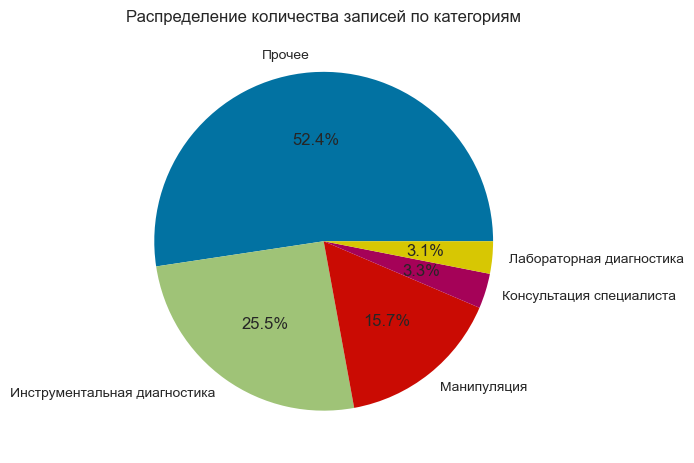

In [9]:
plt.pie(df['Категория'].value_counts(), labels=df['Категория'].unique().tolist(), autopct='%1.1f%%')
plt.title('Распределение количества записей по категориям')
plt.show()

Делаем вывод, что:
    
   - перед нами задача мультиклассовой классификации;
   - наблюдается дисбалас классов;
   - при делении данных на тестовые и тренировочные данные перед обучением моделей необходимо указать stratify по целевой переменной, чтобы все классы были пропорционально распределены по всем выборкам;
   - в части выбора метрики качества будем использовать accuracy - метрику, которая характеризует качество модели, агрегированное по всем классам. Данная метрика быбрана, так как классы для нас имеют одинаковое значение. 

### Распределение длинны текста

In [10]:
lenght = len(df["Название"][1])# Длинна конкретного названия
print(f'Длинна конкретного названия: {lenght}')

Длинна конкретного названия: 37


In [11]:
word_count = df["Название"][1].split()# Количество слов в названии
print(f'Количество слов в образце названия: {len(word_count)}')

Количество слов в образце названия: 5


In [12]:
def word_count(name):
    name_list = name.split()
    return len(name_list)

In [13]:
df['Количество_слов'] = df["Название"].apply(word_count)

In [14]:
# Подсчет средней длинны слова в каждой записи
df['Средняя_длинна_слов'] = df['Название'].map(lambda rev: np.mean([len(word) for word in rev.split()]))

In [15]:
# Средняя длина предложения
np.mean([len(sent) for sent in tokenize.sent_tokenize(df['Название'][0])])

19.0

In [16]:
df['Средняя_длина_записи'] = df['Название'].map(lambda rev: np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))

In [17]:
df

Название  \
0               Стоимость организации услуг, в т.ч. НДС   
1                 Тональная аудиометрия с тестом Вебера   
2                                         Тимпанометрия   
3                                    Офтальмотонометрия   
4                                   Офтальмохромоскопия   
...                                                 ...   
7947  Осмотр (консультация) врача-физиотерапевта пер...   
7948            Консультация врача-гематолога повторная   
7949    Консультация врача - уролога (на дому /в офисе)   
7950  Консультация врача лечебной физкультуры повтор...   
7951  Консультация врача - эндокринолога, терапевта,...   

                         Категория  Количество_слов  Средняя_длинна_слов  \
0                           Прочее                6             5.666667   
1     Инструментальная диагностика                5             6.600000   
2     Инструментальная диагностика                1            13.000000   
3     Инструментальная диагностика                1            18.000000   
4     Инструментальная диагностика                1            19.000000   
...                            ...              ...                  ...   
7947      Консультация специалиста                5            12.000000   
7948      Консультация специалиста                3            12.333333   
7949      Консультация специалиста                8             5.000000   
7950      Консультация специалиста                7             8.142857   
7951      Консультация специалиста                8             8.375000   

      Средняя_длина_записи  
0                     19.0  
1                     37.0  
2                     13.0  
3                     18.0  
4                     19.0  
...                    ...  
7947                  64.0  
7948                  39.0  
7949                  47.0  
7950                  63.0  
7951                  74.0  

[4313 rows x 5 columns]

Нами были созданы дополнительные признаки связанные с колличеством слов и длинной слов по каждой записи для анализа распределения этих признаков.

In [18]:
def visualize(col):
    
    print()
    plt.subplot()
    sns.boxplot(y=df[col], hue=df['Категория'])
    plt.ylabel(col, labelpad=20.5)
    plt.suptitle("Распределение признака "+ col  , fontsize=18, fontweight='bold')
    plt.show()

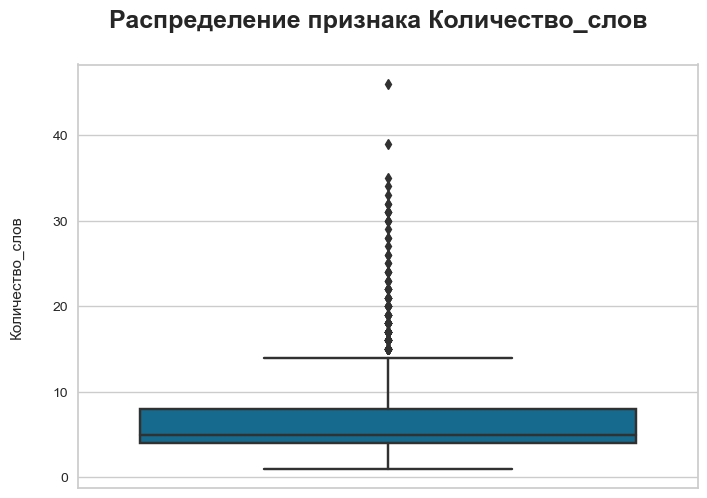

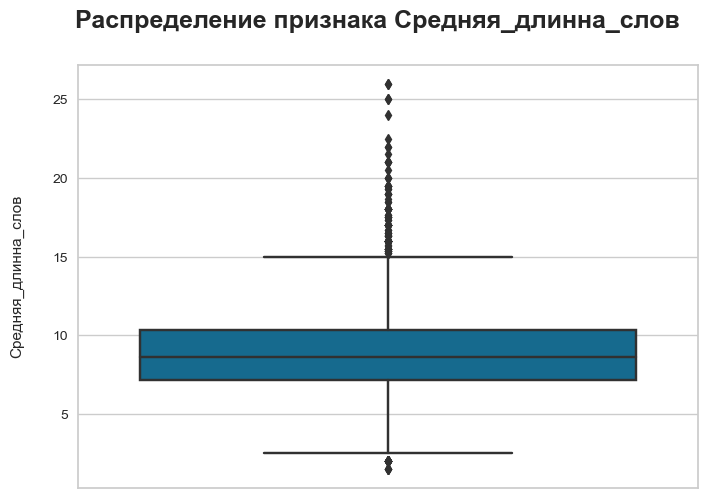

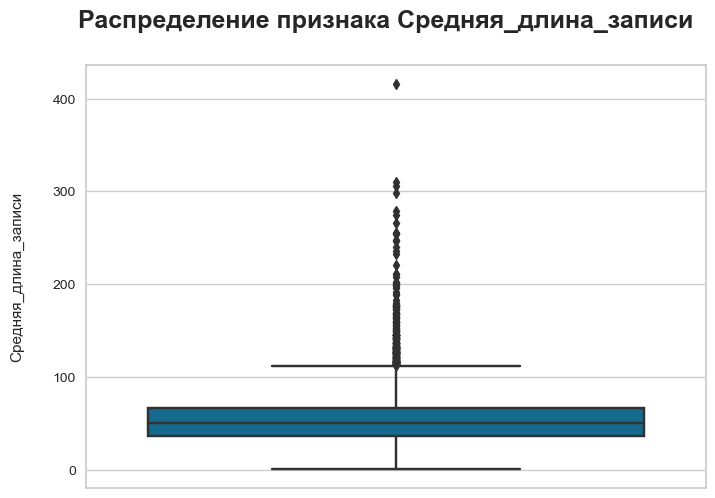

In [19]:
features = df.columns.tolist()[2:]
for feature in features:
    visualize(feature)

Рассмотрим что попало в область явных выбросов с точки зрения распределения.

In [20]:
df.describe()

Количество_слов  Средняя_длинна_слов  Средняя_длина_записи
count      4313.000000          4313.000000           4313.000000
mean          6.287503             8.940355             56.265515
std           3.990931             2.783133             32.183788
min           1.000000             1.500000              1.500000
25%           4.000000             7.166667             37.000000
50%           5.000000             8.625000             51.000000
75%           8.000000            10.333333             67.000000
max          46.000000            26.000000            416.000000

In [21]:
msk_1 = df['Количество_слов'] >= 30
df.loc[msk_1, 'Название'].count()

14

In [22]:
msk_2 = df['Средняя_длинна_слов'] >= 20
df.loc[msk_2, 'Название'].count()

17

In [23]:
msk_3 = df['Средняя_длина_записи'] >= 300
df.loc[msk_3, 'Название'].count()

3

In [24]:
list(df.loc[msk_1, 'Название'])# список выбросов признака Количество_слов

['Ультразвуковое скрининговое иссл-е при сроке берем-ти 11-14 недель по оценке антенатального развития плодов для выявления хромосом. аномалий, пороков развития, рисков задержки роста плода, преждеврем.родов, преэклампсии при многоплод. берем-ти, скрининг I',
 'Гистологическое исследование биопсийного (операционного) материала 1 группы (кожные и подкожные образования (1 локализация), мышечная ткань, придаточные пазухи носа, миндалины (при тонзиллитах), аденоиды, эпулиды, грыжевые мешки, желчный пузырь, стенки раневого канала, ткань свищевого хода и грануляции, аневризма сосуда, варикозно-расширенные вены, геморроидальные узлы, кисты яичника, анальная трещина, аппендикс)',
 'Гистологическое исследование биопсийного (операционного) материала 3 группы (предстательная железа (ТУР и эктомия), легкое, желудок, матка (экстирпация матки  с придатками), кишечник, почка, молочная железа и другие органы и органокомлексы при радикальных операциях)',
 'Гистологическое исследование эндоскопического 

In [25]:
list(df.loc[msk_2, 'Название'])# список выбросов признака Средняя_длинна_слов

['Эхогистеросальпингоскопия',
 'Электроэнцефалография',
 'Электронейромиография',
 'Ректосигмоидоколоноскопия',
 'Офтальмоплетизмография',
 'Эзофагогастродуоденоскопия',
 'Эзофагогастродуоденоскопия',
 'Холедоходуоденоанастомоз',
 'Гистерорезектоскопия',
 'Альфа-2-макроглобулин',
 'Консультация врача-аллерголога-иммунолога',
 'Гистеросальпингография',
 'Рентгеноденситометрия',
 'Компьютерно-томографическая коронарография',
 'Топометрия магнитно-резонансно-томографическая',
 'Магнитно-резонансная холангиопанкреатография',
 'Консультация врача-травматолога-ортопеда.']

In [26]:
list(df.loc[msk_3, 'Название'])# список выбросов признака Средняя_длина_записи

['Гистологическое исследование биопсийного (операционного) материала 1 группы (кожные и подкожные образования (1 локализация), мышечная ткань, придаточные пазухи носа, миндалины (при тонзиллитах), аденоиды, эпулиды, грыжевые мешки, желчный пузырь, стенки раневого канала, ткань свищевого хода и грануляции, аневризма сосуда, варикозно-расширенные вены, геморроидальные узлы, кисты яичника, анальная трещина, аппендикс)',
 'Ультразвуковое скрининговое исследование при сроке беременности одиннадцатая - четырнадцатая недели по оценке антенатального развития плодов с целью выявления хромосомных аномалий, пороков развития, рисков задержки роста плода, преждевременных родов, преэклампсии при многоплодной беременности (скрининг I)',
 'Ультразвуковое скрининговое исследование при сроке беременности девятнадцатая - двадцать первая недели по оценке антенатального развития плодов с целью выявления хромосомных аномалий, пороков развития, рисков задержки роста плода, преждевременных родов, преэклампсии

На основании данных делаем выводы:
- перед обучением моделей потребуеся предобработка текстовых данных;
- нет необходимости в удалении выбросов, будем использовать все записи после проведенной предобработки текста и удаления дубликатов.

### Тональность названий услуг

In [27]:
df = df.drop(features, axis=1)
df.head()

Название                     Категория
0  Стоимость организации услуг, в т.ч. НДС                        Прочее
1    Тональная аудиометрия с тестом Вебера  Инструментальная диагностика
2                            Тимпанометрия  Инструментальная диагностика
3                       Офтальмотонометрия  Инструментальная диагностика
4                      Офтальмохромоскопия  Инструментальная диагностика

In [28]:

regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

In [29]:

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д', '-', '-',
                                           'который','прошлый','сей', 'свой', 'наш', 'мочь', 'ик', 'акг', 'экг', 
                                            'мм', 'фк', 'ч' ]

In [30]:
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [31]:
%%time 
m = Mystem()
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

CPU times: user 410 µs, sys: 488 µs, total: 898 µs
Wall time: 376 µs


In [32]:
for col in text:
    df[col] = df[col].str.lower()
    df[col] = df[col].apply(words_only)
    df[col] = df[col].apply(remove_stopwords)
    df[col] = df[col].apply(lemmatize)

In [33]:
df

Название  \
0                      стоимость организация услуга ндс   
1                     тональный аудиометрия тесто вебер   
2                                         тимпанометрия   
3                                    офтальмотонометрия   
4                                   офтальмохромоскопия   
...                                                 ...   
7947  осмотр консультация врач физиотерапевт первичн...   
7948              консультация врач гематолог повторный   
7949                  консультация врач уролог дом офис   
7950  консультация врач лечебный физкультура повторн...   
7951  консультация врач эндокринолог терапевт ревмат...   

                         Категория  
0                           Прочее  
1     Инструментальная диагностика  
2     Инструментальная диагностика  
3     Инструментальная диагностика  
4     Инструментальная диагностика  
...                            ...  
7947      Консультация специалиста  
7948      Консультация специалиста  
7949      Консультация специалиста  
7950      Консультация специалиста  
7951      Консультация специалиста  

[4313 rows x 2 columns]

In [34]:
lemmata = []
for index, row in df.iterrows():
    lemmata += row['Название'].split()
fd = FreqDist(lemmata)
for i in fd.most_common(20):
    print(i)

('врач', 2321)
('консультация', 1957)
('первичный', 657)
('исследование', 588)
('осмотр', 508)
('повторный', 439)
('кровь', 323)
('терапевт', 298)
('определение', 276)
('дом', 263)
('прием', 229)
('уровень', 191)
('категория', 171)
('антитело', 165)
('гинеколог', 156)
('томография', 153)
('ультразвуковой', 143)
('высокий', 140)
('амбулатория', 130)
('хирург', 127)


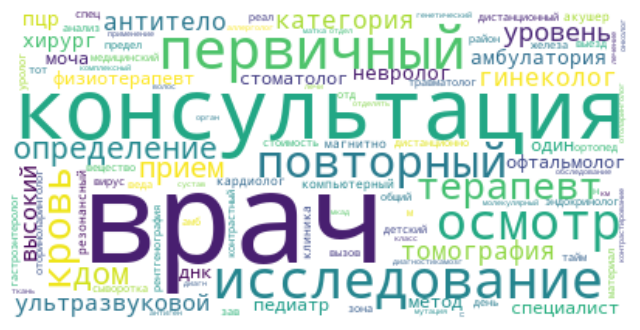

In [35]:
from wordcloud import *
word_freq = [i for i in fd.most_common(100)]
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

Нами была выполнена предобработка текста, которая позволила провести лемматизацию и отобразить облако слов. Полученное облако слов отражает тональность названий услуг. 


Мы не увидили неестественных слов и символов, что свидетельствует о нормальной предобработе текста. Данные этапы предобработки следует использовать для последующей векторизации, в случае использования моделей, для которых такая предобработка потребуется.

## Выводы

В результате анализа были получены следующие данные:
- данные содержат 8451 наблюдений. Состоят из 2 признаков, из них целевой - Категория, задача мультиклассовой классификации;
- количество дубликатов 30.1%;
- наблюдается дисбаланс классов целевого признака;
- отсутствуют пропуски;
- все наименования классов целевого признака уникальны;
- при делении данных на тестовые и тренировочные данные перед обучением моделей необходимо указать stratify по целевой переменной, чтобы все классы были пропорционально распределены по всем выборкам;
- в части выбора метрики качества будем использовать accuracy - метрику, которая характеризует качество модели, агрегированное по всем классам. Данная метрика выбрана, так как классы для нас имеют одинаковое значение;
- перед обучением моделей требуеся предобработка текстовых данных;
- нет необходимости в удалении статистических выбросов;
- получено облако слов, которое отражает тональность названий услуг.

В части обучения моделей предлагается создание связки – TF-IDF + CatBoostClassifier(на основании одного из самых эффективных алгоритмов ML) и трансформера(понимание контекста является главным преимуществом данного подхода).

На основании полученных результатов будут сформулированы возможные варианты дальнейших исследований.

